## IMPORT STATEMENTS

In [ ]:
!pip install inltk
import pandas as pd
import numpy as np
import nltk
import re 
import os
import inltk
from inltk.inltk import setup
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import LancasterStemmer
from sklearn.decomposition import PCA
from collections import defaultdict
import pickle
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## CONDA INSTALL

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:47
🔁 Restarting kernel...


In [ ]:
!conda --version

conda 4.9.2


## STOP WORDS INITIALIZATION

In [ ]:
stop_words = set()
languages = ['english','hindi']
for lang in languages:
    with open(lang+".txt",'r') as f:
        lines = f.readlines()
        for line in lines:
            line = line.rstrip()
            stop_words.add(line)

print(stop_words)

{"a's", 'indeed', 'उस', 'specify', 'briefly', 'appear', 'whom', "it'd", 'seeing', 'itse”', 'until', 'ours', "'tis", 'far', 'sb', 'do', 'other', 'begin', 'even', "they'll", 'पहले', 'corresponding', 'gm', 'दूसरे', 'viz', 'billion', 'sr', 'bs', 'already', 'इन्हें', 'clearly', 'grouped', 'दबारा', 'hi', 'several', 'कि', 'hr', 'इसका', 'are', 'caption', 'e', 'seriously', 'oh', 'bottom', 'yours', 'everyone', 'gave', 'ci', 'poorly', 'backward', 'gg', 'makes', 'ru', 'adj', 'pl', 'go', "you've", 'ch', 'those', 'around', 'page', 'causes', 'finds', 'lower', 'herein', 'say', 'abst', 'ie', 'results', 'कर', 'affecting', 'whole', 'somewhere', 'large', 'herse”', 'gets', '10', 'done', 'following', 'underneath', 'would', 'gmt', 'ne', 'the', 'general', 'backs', 'उनकी', 'msie', 'inc', 'followed', 'pp', 'कोई', 'looking', 'p', 'definitely', 'certain', 'इस', 'work', 'hn', 'used', 'um', 'ended', 'साबुत', 'ir', 'awfully', 'fx', 'less', 'unlikely', 'रहे', 'asked', "what'll", 'gone', 'मानो', 'dk', 'oldest', 'any',

## DATA PREPROCESSING

In [ ]:
def data_cleaning(tweet_array,tweet_id,length):
  # using nltk twitter tokenizer
    lemmatizer = nltk.stem.WordNetLemmatizer()
    lancaster=LancasterStemmer()
    processed_review=[]
    mapping = dict()
    single_review = ""
    for index in range(0,length):
        single_review = tweet_array[index]
        # remove html tags
        single_review = re.sub('<.*?>',' ',single_review)
        # remove single characters
        single_review = re.sub('\s+[a-zA-Z]\s+',' ', single_review)
        # remove multiple spaces 
        single_review = re.sub('\s+',' ', single_review)
        # use twitter tokenizer
        tk = TweetTokenizer()
        word_tokens = tk.tokenize(single_review)
        lemmatized_sentence = " ".join(lemmatizer.lemmatize(token) for token in word_tokens if token not in stop_words)
        processed_review.append(lemmatized_sentence)
        mapping[tweet_id[index]] = single_review

    
    return processed_review, mapping

In [ ]:
# This function takes tweets as input and preprocess it consider tweet id
def data_preprocessing(df):
  # finding different languages and considering only english and hindi
  print("unique languages are",df.language.unique())
  en_df = df.loc[df['language']=='en']
  hi_df = df.loc[df['language']=='hi']
  print("english tweets shape is",en_df.shape)
  print("hindi tweets shape is",hi_df.shape)
  english_content = np.array(en_df.content)
  hindi_content = np.array(hi_df.content)
  english_tweet_id = np.array(en_df.tweet_id)
  hindi_tweet_id = np.array(hi_df.tweet_id)
  length1 = en_df.shape[0]
  length2 = hi_df.shape[0]
  english_tweets, en_id_content = data_cleaning(english_content,english_tweet_id, length1)
  hindi_tweets, hi_id_content  = data_cleaning(hindi_content,hindi_tweet_id,length2)
  return english_tweets, hindi_tweets, en_id_content, hi_id_content


In [ ]:
pulwama_url = 'https://raw.githubusercontent.com/abhiram144/Copy-Pasta-Analysis/main/user_tweets/pulwama_attack.csv'
df = pd.read_csv(pulwama_url)
english_tweets, hindi_tweets, en_mapping, hi_mapping = data_preprocessing(df)

unique languages are ['en' 'hi' 'und' 'et' 'ca' 'in' 'sl' 'ro' 'mr' 'tl' 'ta' 'it' 'eu' 'es' 'pt' 'fi' 'pa' 'ne' 'cy' 'gu' 'da' 'te' 'ml'
 'kn' 'sv' 'ht' 'pl' 'bn' 'fr' 'or' 'de' 'vi' 'tr' 'lv' 'ko' 'cs' 'hu' 'no' 'nl']
english tweets shape is (17755, 13)
hindi tweets shape is (23993, 13)


## USER DATA LOADING

In [ ]:
party_url = 'https://raw.githubusercontent.com/abhiram144/Copy-Pasta-Analysis/main/user_tweets/user_data.csv'
df_party_names = pd.read_csv(party_url)
user_details_url = 'https://raw.githubusercontent.com/abhiram144/Copy-Pasta-Analysis/main/user_tweets/user_details.csv'
df_user_data = pd.read_csv(user_details_url)

In [ ]:
df_party_names.head()

,Unnamed: 0,verified,location,id,url,public_metrics,protected,party,username,name,created_at,description
0,0,True,"Punjab, India",3153134184,NaN,"{'followers_count': 58375, 'following_count': ...",False,BJP,sunilkjakhar,Sunil Jakhar,2015-04-13T16:14:06.000Z,NaN
1,1,True,NEW DELHI,45795876,NaN,"{'followers_count': 21332, 'following_count': ...",False,BJP,rpsinghkhalsa,RP Singh National Spokesperson BJP,2009-06-09T08:33:22.000Z,"Advertising Professional.\nPatron, Gali Pathsh..."
2,2,True,Dehradun,1297926962,https://t.co/SkirgMiB7f,"{'followers_count': 1907, 'following_count': 2...",False,BJP,bjpnareshbansal,Naresh Bansal,2013-03-25T06:31:52.000Z,Member of Parliament Rajya Sabha | Ex. General...
3,3,True,pokhari chamoli uttarakhand,2692838006,https://t.co/9j75o0vuWo,"{'followers_count': 5481, 'following_count': 3...",False,BJP,mahendrabhatbjp,Mahendra Bhatt MLA,2014-07-30T13:02:25.000Z,महेंद्र भट्ट विधायक बद्रीनाथ विधानसभा उत्तराखं...
4,4,True,"Yamkeshwar, India",1028186624218288128,https://t.co/SxS5stdGzU,"{'followers_count': 2602, 'following_count': 1...",False,BJP,RituKhanduriBJP,Ritu Khanduri Bhushan,2018-08-11T07:49:28.000Z,Official Account of Smt. Ritu Khanduri Bhushan...


In [ ]:
df_user_data.head()

,username,id,displayname,followersCount,friendsCount,location
0,BJP4JnK,1864685238,BJP Jammu & Kashmir,86433,222,Jammu & Kashmir
1,GulabMatiala,2922933098,Gulab Singh,38727,716,"New Delhi, India"
2,guptaravinder71,2204739805,Ravinder Gupta 🇮🇳,23358,1234,"Karol Bagh, New Delhi"
3,MaheishGirri,425973946,Maheish Girri,133913,657,"New Delhi, India"
4,shweta_shalini,2366619296,Shweta Shalini,22684,374,Mumbai


## PERFORM EMBEDDING

In [ ]:
from sentence_transformers import SentenceTransformer
sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')

In [ ]:
def perform_encoding(tweets):
  sentence_embeddings = sbert_model.encode(tweets)
  return sentence_embeddings

In [ ]:
# saving embeddings in pickle file
def save_embedding(sentence_embeddings):
  with open('doc_embedding.pickle', 'wb') as pkl:
    pickle.dump(sentence_embeddings, pkl)

In [ ]:
sentence_embeddings = perform_encoding(english_tweets)
save_embedding(sentence_embeddings)

## LOAD EMBEDDING

In [ ]:
def load_embedding():
  with open('doc_embedding.pickle','rb') as pkl:
    sentence_embedding = pickle.load(pkl)
  return sentence_embedding

In [ ]:
sentence_embedding = load_embedding()

## DIMENSIONALITY REDUCTION

In [ ]:
def dimensionality_reduction(dimensions,sentence_embeddings):
  pca = PCA(n_components = dimensions)
  principal_components = pca.fit_transform(sentence_embeddings)
  return principal_components

In [ ]:
p_component = dimensionality_reduction(10,sentence_embedding)

## CREATE MAPPING BETWEEN TWEET_ID AND EMBEDDING

In [ ]:
# This function creates mapping between embedding and tweet id
from collections import defaultdict
def reverse_mapping(p_component,en_mapping):
  rev_map = defaultdict(list)
  index = 0
  for tweet_id in en_mapping.keys():
    tupple = tuple(p_component[index])
    rev_map[tupple].append(tweet_id)
    index = index+1 
  print(index)
  return rev_map

In [ ]:
print(p_component.shape)
rev_map = reverse_mapping(p_component,en_mapping)
print(len(rev_map))


(17755, 10)
17755
17479


## PERFORM HIERARCHIAL CLUSTERING

In [ ]:
# This method is used to perform hierarchial clustering
from scipy.cluster import  hierarchy
def hierarchial_clustering(p_component,distance_threshold):
  Z = hierarchy.linkage(p_component,"average", metric="cosine")
  C = hierarchy.fcluster(Z, distance_threshold, criterion="distance")
  return C


In [ ]:
distance_threshold = 0.04
cluster_obj = hierarchial_clustering(p_component, distance_threshold)

## PERFORM ANALYSIS ON CLUSTERING OBJECT

In [ ]:
df.head()

,tweet_id,user_name,date,content,language,reply_count,retweet_count,like_count,hashtags,coordinates,place,cashtags,mentionedUsers
0,1101076008827060226,BJP4JnK,2019-02-28T11:05:52+00:00,#MeraBoothSabseMazboot\nGlimpses of Live Inter...,en,0,5,13,['MeraBoothSabseMazboot'],NaN,NaN,NaN,[]
1,1101051875011579904,BJP4JnK,2019-02-28T09:29:58+00:00,देश चल पड़ा है प्रगति पथ पर\nबस यूं ही चलते रह...,hi,0,16,27,['MeraBoothSabseMazboot'],NaN,NaN,NaN,[]
2,1101038475632144384,BJP4JnK,2019-02-28T08:36:43+00:00,"देश ने करवट बदली है, यह तो बस अंगड़ाई है आगे औ...",hi,0,10,14,['MeraBoothSabseMazboot'],NaN,NaN,NaN,['narendramodi']
3,1101035670439686144,BJP4JnK,2019-02-28T08:25:34+00:00,इस बार कुम्भ की स्वच्छता को लेकर पूरी दुनिया म...,hi,1,55,106,NaN,NaN,NaN,NaN,['narendramodi']
4,1101035022323195904,BJP4JnK,2019-02-28T08:23:00+00:00,बरसों से था घना अँधेरा अब जाके भोर दिखी है\nउन...,hi,0,12,15,['MeraBoothSabseMazboot'],NaN,NaN,NaN,['narendramodi']


In [ ]:
# This function is used to get number of clusters
def number_of_clusters(cluster_obj):
  unique_list = cluster_obj.tolist()
  unique_list = list(set(unique_list))
  return len(unique_list)

In [ ]:
# This function is returns list of cluster id with more than 3 elements in it
def cluster_id_list(cluster_obj):
  id_list = list()
  counter = defaultdict(lambda:0)
  for id in cluster_obj:
      counter[id] = counter[id] +1
  for key in counter.keys():
      if counter[key] >= 2:
        id_list.append(key)
  return id_list


In [ ]:
import math
def get_hash_tag_list(id):
  temp_df = df.loc[df['tweet_id'] == id]
  hashtags = temp_df['hashtags']
  temp_list = list()
  for index, value in hashtags.items():
    # format the value
    
    if type(value) is not float:
      value = value[1:-1]
      split_list = value.split(", ")
      for s_list in split_list:
        s_list = s_list[1:-1]
        temp_list.append(s_list)
  return temp_list

In [ ]:
# This function is used to traverse the id list and print all tweets pertaining in that id
def print_tweets_in_cluster(id_list,cluster_obj,rev_map,en_mapping,p_component,hash_tag_counter):
  # traverse id in id_list
  for id in id_list:
    p_comp_index = list()
    for index in range(0,len(cluster_obj)):
      if cluster_obj[index] == id:
        p_comp_index.append(index)
    
    # got principle component index get tweet content
    print("cluster id is:",id)
    for index in p_comp_index:
      # get tweet id
      tweet_id_list = rev_map[tuple(p_component[index])]
      
      for id in tweet_id_list:
        # get hash tag from id
        hash_tag = get_hash_tag_list(id)
        for h_t in hash_tag:
          
          hash_tag_counter[h_t] = hash_tag_counter[h_t] + 1
          print(en_mapping[id]) 

      

In [ ]:
def party_vs_copies(id_list,cluster_obj,rev_map,en_mapping,p_component,hash_tag_counter):
 # traverse id in id_list
 party_wise_counts={'BJP':0,'Congress':0,'AAP':0}
 for id in id_list:
   p_comp_index = list()
   for index in range(0,len(cluster_obj)):
     if cluster_obj[index] == id:
       p_comp_index.append(index)
  
   # got principle component index get tweet content
   #print("cluster id is:",id)
   for index in p_comp_index:
     # get tweet id
     tweet_id_list = rev_map[tuple(p_component[index])]
     
     x=df.loc[df['tweet_id'].isin(tweet_id_list)]
     x=x['user_name']
     y=df_party_names[['username','party']]
     z=pd.merge(x,y,'inner',left_on='user_name',right_on='username')
     counts=z['party'].value_counts()
     for val in counts.index:
       party_wise_counts[val]+=counts[val]
     
 return party_wise_counts

In [ ]:
# This function is used to get tweet ids for every cluster
def tweet_id_per_cluster(id_list,cluster_obj,rev_map,en_mapping,p_component,hash_tag_counter):
  # traverse id in id_list
  cluster_tweet_id_mapping = defaultdict(list)
  for id in id_list:
    p_comp_index = list()
    for index in range(0,len(cluster_obj)):
      if cluster_obj[index] == id:
        p_comp_index.append(index)
    
    for index in p_comp_index:
      tweet_id_list = rev_map[tuple(p_component[index])]
      for t_id in tweet_id_list:
        cluster_tweet_id_mapping[id].append(t_id)
      
  return cluster_tweet_id_mapping


In [ ]:
number = number_of_clusters(cluster_obj)
print("number of clusters :", number )

number of clusters : 11421


In [ ]:
id_list = cluster_id_list(cluster_obj)
print(id_list)

[6007, 6441, 7328, 7318, 2964, 2188, 4141, 8867, 2131, 2589, 2696, 1714, 7350, 2190, 6080, 8757, 1616, 2222, 1121, 6533, 6081, 5921, 9554, 5938, 5888, 10287, 6078, 9285, 2392, 10899, 4235, 6835, 4569, 4252, 3509, 13, 11274, 3421, 5779, 342, 5031, 9801, 4508, 3695, 6964, 3913, 4053, 2134, 4214, 4718, 4721, 4022, 2948, 1586, 4501, 9978, 10826, 363, 5945, 4893, 749, 3852, 6247, 4397, 8376, 2373, 7267, 7107, 7226, 10605, 10602, 8872, 9403, 2322, 6436, 7466, 6236, 2704, 4466, 8482, 10665, 8484, 8476, 8485, 8489, 8490, 8565, 8493, 8495, 797, 10663, 4209, 3781, 8908, 8050, 2943, 2244, 2176, 8462, 1745, 7985, 2674, 7998, 10994, 4227, 10892, 11066, 5369, 6730, 6685, 3586, 1105, 10656, 2550, 10741, 8327, 11084, 10715, 1002, 10627, 1974, 1130, 11052, 11316, 1109, 7964, 4607, 4218, 4246, 4213, 4191, 4258, 4187, 603, 4140, 4565, 9991, 3874, 3773, 10463, 4145, 4488, 3235, 4202, 3767, 4146, 4076, 4109, 8113, 8868, 6041, 3708, 4330, 4512, 6793, 6411, 2793, 7152, 437, 4219, 5305, 9268, 2098, 5994, 2258

In [ ]:
print("number_of_clusters",len(id_list))

number_of_clusters 2641


In [ ]:
hash_tag_counter = defaultdict(lambda:0)
print_tweets_in_cluster(id_list,cluster_obj,rev_map,en_mapping,p_component,hash_tag_counter)

In [ ]:
party_wise_counts=party_vs_copies(id_list,cluster_obj,rev_map,en_mapping,p_component,hash_tag_counter)

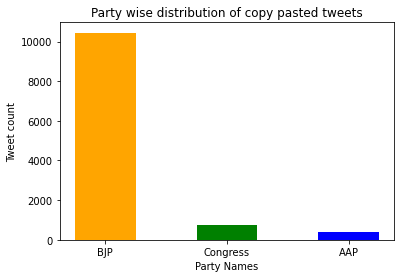

In [ ]:
import matplotlib.pyplot as plt
party = list(party_wise_counts.keys())
counts = list(party_wise_counts.values())
plt.bar(party, counts, color =['orange','green','blue'],
        width = 0.5)
plt.xlabel("Party Names")
plt.ylabel("Tweet count")
plt.title("Party wise distribution of copy pasted tweets")
plt.show()

### Displaying Hash Tags and Count

In [ ]:
hash_tag_counter=sorted(hash_tag_counter.items(), key = lambda kv:(kv[1], kv[0]),reverse = True)

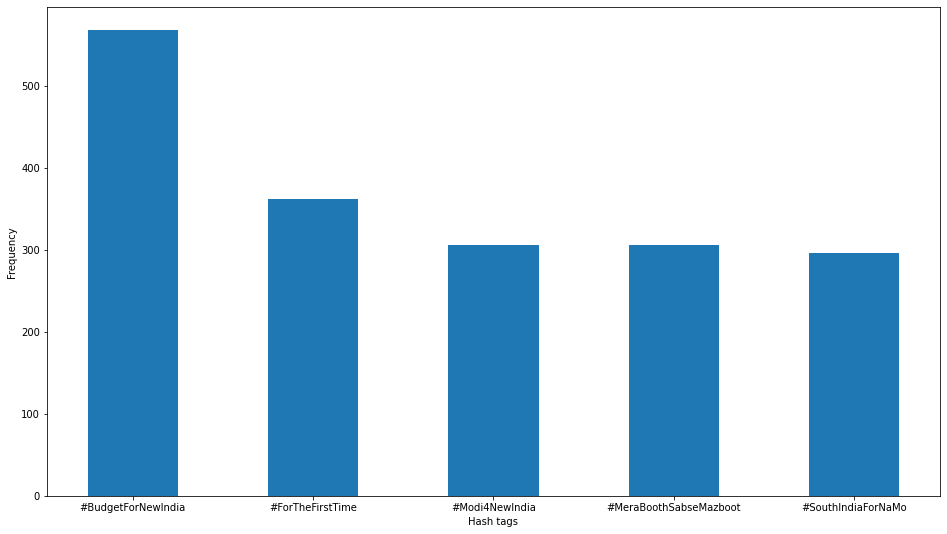

In [ ]:
hash_tags=["#"+x[0] for x in hash_tag_counter[:5]]
frequency=[x[1] for x in hash_tag_counter[:5]]
plt.figure(figsize=(16,9))
plt.bar(hash_tags, frequency,
       width = 0.5)
plt.xlabel("Hash tags")
plt.ylabel("Frequency")
plt.show()

## cluster tweet id mapping

In [ ]:
cluster_tweet_id_mapping = tweet_id_per_cluster(id_list,cluster_obj,rev_map,en_mapping,p_component,hash_tag_counter)

## user_copy_paste_count

In [ ]:
copy_paste_count = defaultdict(lambda:0)
for k,v in cluster_tweet_id_mapping.items():
  if(len(v)>10):
    for tweet_id in v:
      x=df.loc[df['tweet_id']==tweet_id]
      user_name=x.iloc[0]['user_name']
      user_name=str(user_name)
      if(user_name[:4].lower()!="bjp4"):
        y=df_party_names.loc[df_party_names['username']==user_name]
        if(len(y)>0):
          party_name=str(y.iloc[0]['party'])
          copy_paste_count[(user_name,party_name)] = copy_paste_count[(user_name,party_name)] + 1
        

s=sorted(copy_paste_count.items(),key=lambda kv:(kv[1],kv[0]),reverse=True)[:10]

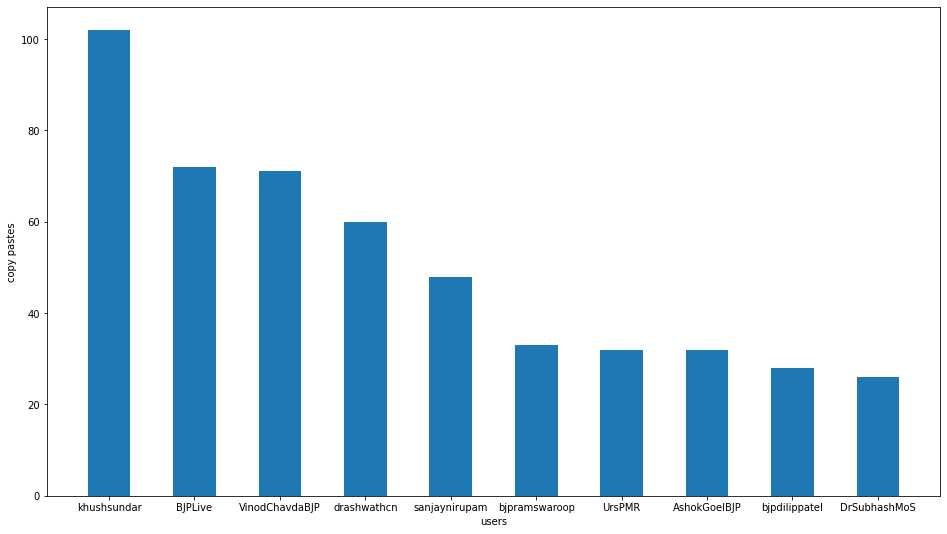

In [ ]:
users=[k[0][0] for k in s]
counts=[k[1] for k in s]
plt.figure(figsize=(16,9))
plt.bar(users, counts,
       width = 0.5)
plt.xlabel("users")
plt.ylabel("copy pastes")
plt.show()

In [ ]:
celebrities=[('khushsundar', 104),('VinodChavdaBJP', 70),()]

## FOLLOWERS VS COPY PASTE

In [ ]:
followers_count={}
for k in copy_paste_count.keys():
 username=k[0]
 y=df_user_data.loc[df_user_data['username']==username]
 fc=y.iloc[0]['followersCount']
 followers_count[username]=fc

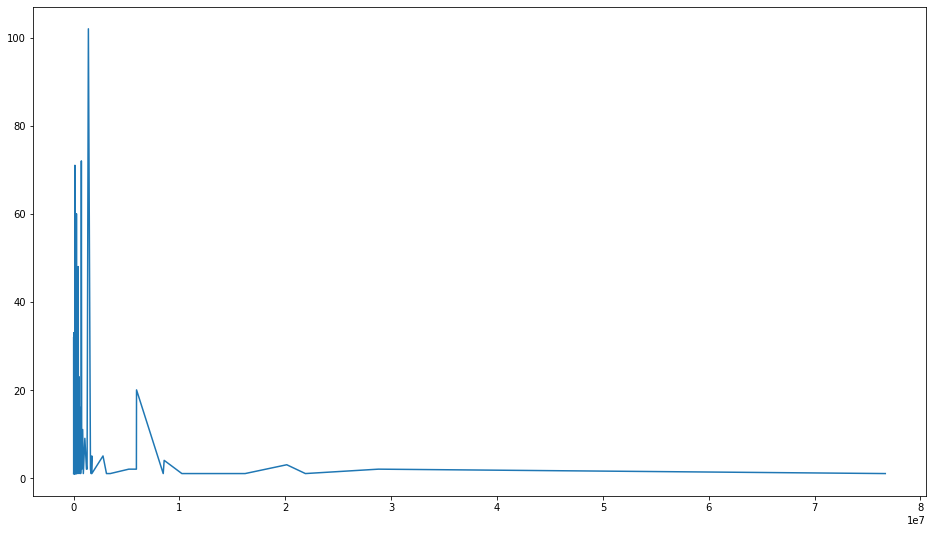

In [ ]:
temp=[(v1,v2) for v1,v2 in zip(followers_count.values(),copy_paste_count.values())]
temp=sorted(temp)
no_of_followers=[v[0] for v in temp]
copy_count=[v[1] for v in temp]
plt.figure(figsize=(16,9))
plt.plot(no_of_followers,copy_count)
plt.show()


## ANALYSING HINDI TWEETS

In [ ]:
!pip uninstall torch

In [ ]:
!conda install pytorch==1.3.0 -c pytorch

Solving environment: | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - pytorch==1.3.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _openmp_mutex-4.5          |           1_llvm           5 KB  conda-forge
    ca-certificates-2021.10.8  |       ha878542_0         139 KB  conda-forge
    certifi-2021.10.8          |   py37h89c1867_2         145 KB  conda-forge
    conda-4.12.0               |   py37h89c1867_0         1.0 MB  conda-forge
    cpuonly-1.0                |                0           2 KB  pytorch
    cudatoolkit-11.1.1         |       h6406543_8        1.20 GB  conda-forge
    l

In [ ]:
setup('hi')

RuntimeError: ignored

Done!


In [ ]:
from inltk.inltk import get_sentence_encoding
def perform_hindi_encoding(hindi_tweets):
  # traverse tweets
  # creating an empty nd array
  hindi_embedding = np.empty((0,400),float)
  for t in hindi_tweets:
     encoding = get_sentence_encoding(t,'hi')
     hindi_embedding = np.append(hindi_embedding, encoding, axis=0)
  
  print(hindi_embedding.shape)
  return hindi_embedding

In [ ]:
hindi_embeddings = perform_hindi_encoding(hindi_tweets)

/usr/local/lib/python3.7/site-packages/torch/serialization.py:786: SourceChangeWarning: source code of class 'torch.nn.modules.loss.CrossEntropyLoss' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/site-packages/torch/serialization.py:786: SourceChangeWarning: source code of class 'fastai.text.models.awd_lstm.AWD_LSTM' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/site-packages/torch/serialization.py:786: SourceChangeWarning: source code of class 'torch.nn.modules.sparse.Embedding' has changed. you can retrieve the original source code by accessing the object's source attribu

AttributeError: ignored